In [1]:
#HW05

In [2]:
from __future__ import annotations

from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression


## 1) Пути и загрузка данных

In [3]:
# Папка HW05 (где лежит этот ноутбук)
HW05_DIR = Path.cwd()

# Датасет — должен лежать рядом: homeworks/HW05/S05-hw-dataset.csv
DATA_PATH = HW05_DIR / "S05-hw-dataset.csv"

if not DATA_PATH.exists():
    raise FileNotFoundError(
        f"Не найден файл датасета: {DATA_PATH}\n"
        "Проверь, что ты открыл ноутбук именно из папки homeworks/HW05 "
        "и что CSV лежит рядом с ноутбуком."
    )

df = pd.read_csv(DATA_PATH)
df.shape


(3000, 17)

## 2) Мини-EDA (как требует задание)

In [4]:
df.head()


,client_id,age,income,years_employed,credit_score,debt_to_income,num_credit_cards,num_late_payments,has_mortgage,has_car_loan,savings_balance,checking_balance,region_risk_score,phone_calls_to_support_last_3m,active_loans,customer_tenure_years,default
0,1,25,94074,22,839,0.547339,1,7,0,0,26057,5229,0.080052,19,1,8,0
1,2,58,51884,26,565,0.290882,1,1,0,1,16221,11595,0.428311,15,0,7,0
2,3,53,48656,39,561,0.522340,1,13,0,0,55448,-2947,0.770883,15,4,5,0
3,4,42,81492,30,582,0.709123,2,10,1,1,35188,17727,0.357619,0,2,7,1
4,5,42,94713,8,642,0.793392,3,3,0,0,0,-404,0.414260,17,1,10,1


In [5]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   client_id                       3000 non-null   int64  
 1   age                             3000 non-null   int64  
 2   income                          3000 non-null   int64  
 3   years_employed                  3000 non-null   int64  
 4   credit_score                    3000 non-null   int64  
 5   debt_to_income                  3000 non-null   float64
 6   num_credit_cards                3000 non-null   int64  
 7   num_late_payments               3000 non-null   int64  
 8   has_mortgage                    3000 non-null   int64  
 9   has_car_loan                    3000 non-null   int64  
 10  savings_balance                 3000 non-null   int64  
 11  checking_balance                3000 non-null   int64  
 12  region_risk_score               30

In [6]:
df.describe(include='all').T


,count,mean,std,min,25%,50%,75%,max
client_id,3000.0,1500.500000,866.169729,1.000000,750.750000,1500.500000,2250.250000,3000.000000
age,3000.0,45.059667,14.192883,21.000000,33.000000,45.000000,57.000000,69.000000
income,3000.0,69658.992000,24742.235182,15000.000000,52641.750000,69784.500000,85874.250000,156351.000000
years_employed,3000.0,19.577667,11.381497,0.000000,10.000000,20.000000,29.000000,39.000000
credit_score,3000.0,649.285333,69.955852,402.000000,604.000000,647.000000,697.000000,850.000000
debt_to_income,3000.0,0.284065,0.161112,0.006147,0.157796,0.261726,0.388886,0.878343
num_credit_cards,3000.0,3.494667,2.289917,0.000000,1.000000,3.000000,6.000000,7.000000
num_late_payments,3000.0,6.869333,4.291278,0.000000,3.000000,7.000000,10.000000,14.000000
has_mortgage,3000.0,0.495000,0.500058,0.000000,0.000000,0.000000,1.000000,1.000000
has_car_loan,3000.0,0.501333,0.500082,0.000000,0.000000,1.000000,1.000000,1.000000


### Распределение таргета `default`

In [7]:
if "default" not in df.columns:
    raise ValueError("В датасете нет столбца 'default' — проверь файл CSV.")

target_share = df["default"].value_counts(normalize=True)
target_counts = df["default"].value_counts()
target_counts, target_share


(default
 0    1769
 1    1231
 Name: count, dtype: int64,
 default
 0    0.589667
 1    0.410333
 Name: proportion, dtype: float64)

## 3) Подготовка X/y и train/test split

In [8]:
X = df.drop(columns=["default"])
y = df["default"].astype(int)

# стратификация важна при дисбалансе
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

X_train.shape, X_test.shape


((2400, 16), (600, 16))

## 4) Препроцессинг: числовые + категориальные
Мы делаем пайплайн:
- числовые: `StandardScaler()`
- категориальные: `OneHotEncoder(handle_unknown='ignore')`

In [9]:
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = [c for c in X.columns if c not in numeric_features]

numeric_features, categorical_features


(['client_id',
  'age',
  'income',
  'years_employed',
  'credit_score',
  'debt_to_income',
  'num_credit_cards',
  'num_late_payments',
  'has_mortgage',
  'has_car_loan',
  'savings_balance',
  'checking_balance',
  'region_risk_score',
  'phone_calls_to_support_last_3m',
  'active_loans',
  'customer_tenure_years'],
 [])

In [10]:
preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ],
    remainder="drop",
)

preprocess


,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers contains sparse matrices,these will be stacked as a sparse matrix if the overall density islower than this value. Use ``sparse_threshold=0`` to always returndense. When the transformed output consists of all dense data, thestacked result will be dense, and this keyword will be ignored.",0.3
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details.",None
,"transformer_weights transformer_weights: dict, default=NoneMultiplicative weights for features per transformer. The output of thetransformer is multiplied by these weights. Keys are transformer names,values the weights.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each transformer will beprinted as it is completed.",False
,"verbose_feature_names_out verbose_feature_names_out: bool, str or Callable[[str, str], str], default=True- If True, :meth:`ColumnTransformer.get_feature_names_out` will prefix all feature names with the name of the transformer that generated that feature. It is equivalent to setting `verbose_feature_names_out=""{transformer_name}__{feature_name}""`.- If False, :meth:`ColumnTransformer.get_feature_names_out` will not prefix any feature names and will error if feature names are not unique.- If ``Callable[[str, str], str]``, :meth:`ColumnTransformer.get_feature_names_out` will rename all the features using the name of the transformer. The first argument of the callable is the transformer name and the second argument is the feature name. The returned string will be the new feature name.- If ``str``, it must be a string ready for formatting. The given string will be formatted using two field names: ``transformer_name`` and ``feature_name``. e.g. `

## 5) Бейзлайн: DummyClassifier

In [11]:
dummy = Pipeline(
    steps=[
        ("preprocess", preprocess),
        ("model", DummyClassifier(strategy="most_frequent", random_state=42)),
    ]
)

dummy.fit(X_train, y_train)

dummy_pred = dummy.predict(X_test)
# predict_proba нужен для ROC-AUC
dummy_proba = dummy.predict_proba(X_test)[:, 1]

dummy_acc = accuracy_score(y_test, dummy_pred)
dummy_auc = roc_auc_score(y_test, dummy_proba)

dummy_acc, dummy_auc


(0.59, 0.5)

## 6) Логистическая регрессия (несколько C)
Попробуем несколько значений **C** (чем больше C, тем слабее регуляризация).

In [12]:
Cs = [0.1, 1.0, 10.0]

results = []

for C in Cs:
    logreg = Pipeline(
        steps=[
            ("preprocess", preprocess),
            ("model", LogisticRegression(
                C=C,
                max_iter=2000,
                solver="lbfgs",
            )),
        ]
    )
    logreg.fit(X_train, y_train)

    pred = logreg.predict(X_test)
    proba = logreg.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, pred)
    auc = roc_auc_score(y_test, proba)

    results.append({"model": f"LogReg(C={C})", "accuracy": acc, "roc_auc": auc})

results


[{'model': 'LogReg(C=0.1)',
  'accuracy': 0.8033333333333333,
  'roc_auc': 0.8754076523816086},
 {'model': 'LogReg(C=1.0)',
  'accuracy': 0.8016666666666666,
  'roc_auc': 0.875556933535437},
 {'model': 'LogReg(C=10.0)', 'accuracy': 0.8, 'roc_auc': 0.8755224840383997}]

## 7) Сводная таблица: Dummy vs LogReg

In [13]:
summary_rows = [{"model": "Dummy(most_frequent)", "accuracy": dummy_acc, "roc_auc": dummy_auc}] + results
summary = pd.DataFrame(summary_rows).sort_values(["roc_auc", "accuracy"], ascending=False)
summary


,model,accuracy,roc_auc
2,LogReg(C=1.0),0.801667,0.875557
3,LogReg(C=10.0),0.800000,0.875522
1,LogReg(C=0.1),0.803333,0.875408
0,Dummy(most_frequent),0.590000,0.500000


## 8) ROC-кривая лучшей модели и сохранение в файл

WindowsPath('C:/Users/Professional/Desktop/repository-julia-gr1-main/homeworks/HW05/figures/roc_curve.png')

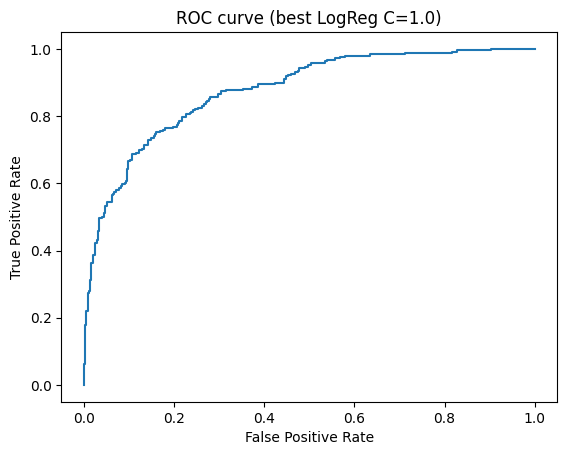

In [14]:
# выберем лучшую модель по ROC-AUC среди LogReg
best = max(results, key=lambda x: x["roc_auc"])
best_C = float(best["model"].split("C=")[1].split(")")[0])

best_model = Pipeline(
    steps=[
        ("preprocess", preprocess),
        ("model", LogisticRegression(C=best_C, max_iter=2000, solver="lbfgs")),
    ]
)
best_model.fit(X_train, y_train)
best_proba = best_model.predict_proba(X_test)[:, 1]

fpr, tpr, thr = roc_curve(y_test, best_proba)

plt.figure()
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC curve (best LogReg C={best_C})")

FIG_DIR = HW05_DIR / "figures"
FIG_DIR.mkdir(exist_ok=True)
out_path = FIG_DIR / "roc_curve.png"
plt.savefig(out_path, dpi=150, bbox_inches="tight")
out_path


## 9) Короткий отчёт
В качестве бейзлайна использовалась модель DummyClassifier со стратегией most_frequent, которая всегда предсказывает самый частый класс. Такая модель не использует признаки и служит нижней оценкой качества. Её accuracy составила около 0.59, а значение ROC-AUC = 0.5, что соответствует случайному угадыванию.

Логистическая регрессия показала значительно лучшие результаты: accuracy выросла до ≈0.80, а ROC-AUC — до ≈0.875. Это говорит о том, что модель действительно извлекает полезную информацию из признаков и хорошо разделяет классы.

Изменение параметра регуляризации C слабо повлияло на итоговое качество: все рассмотренные значения дали близкие результаты, с небольшим преимуществом при C = 1.0. Это означает, что модель устойчива и не слишком чувствительна к настройке регуляризации.

В целом логистическая регрессия существенно превосходит бейзлайн и может рассматриваться как базовая рабочая модель для задачи кредитного дефолта. ROC-кривая подтверждает хорошее качество классификации на разных порогах.